# GPT Agent Swarm
This notebook uses the OpenAI API to create a swarm of Assistants that will be used to create 8 classification models for a model stacking project. The data set is split into 5 folds of data, reserving the 5th fold being reserved for validation of the final model. The dataset used in this study is the Wisconsin Breast Cancer Dataset, downloaded from the UCI Data Repository. 

In [23]:
!pip install openai

In [24]:
import openai
import time
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
from io import StringIO
import io
import json

## Define Functions

def read_and_save_file(first_file_id, file_name):    
    # its binary, so read it and then make it a file like object
    file_data = client.files.content(first_file_id)
    file_data_bytes = file_data.read()
    file_like_object = io.BytesIO(file_data_bytes)
    #now read as csv to create df
    returned_data = pd.read_csv(file_like_object)
    returned_data.to_csv(file_name, index=False)
    return returned_data
    # file = read_and_save_file(first_file_id, "analyst_output.csv")
    
def files_from_messages(messages, asst_name):
    first_thread_message = messages.data[0]  # Accessing the first ThreadMessage
    message_ids = first_thread_message.file_ids
    print(message_ids)
    # Loop through each file ID and save the file with a sequential name
    for i, file_id in enumerate(message_ids):
        file_name = f"{asst_name}_output_{i+1}.csv"  # Generate a sequential file name
        read_and_save_file(file_id, file_name)
        print(f'saved {file_name}')    
        
def spin_up(target, base_instructions, file_id):
    # create assistant
    my_assistant = client.beta.assistants.create(
        instructions=base_instructions,
        name="agent",
        tools=[{"type": "code_interpreter"}],
        model="gpt-4-1106-preview", # gpt-4
        file_ids=file_id)
    message_string = "Please execute your ACTIONS on the csv file, the target field is " + target
    # Create a Thread
    thread = client.beta.threads.create()
    # Add a Message to a Thread
    message = client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content= message_string)
    # Run the Assistant
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=my_assistant.id)
    return my_assistant, thread, run 
    print('Finished creating Assistants')
    #assistant, thread, run = spin_up(n, base_instructions, file_id)    
    
def catch_response(assistant, thread, run):
    #time.sleep(240)  
    # Retrieve the run status
    run_status = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id)
    print('Checking for response...')
    # If run is completed, get messages
    if run_status.status == 'completed':
        messages = client.beta.threads.messages.list(
            thread_id=thread.id)
        # Loop through messages and print content based on role
        for msg in messages.data:
            role = msg.role
            try:
                content = msg.content[0].text.value
                print(f"{role.capitalize()}: {content}")
                return messages, content
            except AttributeError:
                # This will execute if .text does not exist
                print(f"{role.capitalize()}: [Non-text content, possibly an image or other file type]")
    else:
        print('no response yet')
    #messages, content = catch_response(assistant, thread, run)   
    
def spin_down(my_assistant_id):
    response = client.beta.assistants.delete(my_assistant_id)
    print(response)  
    #spin_down(my_assistant_id)

def upload_csv(file_name):
    response = client.files.create(
        file=open(file_name, "rb"),
        purpose="assistants")
    print(response)
    file_id = response.id
    return file_id

def delete_all_assistant_files():
    ''' Deletes all exising files uploaded to client using API key '''
    # generate a files object
    files_object = client.files.list()
    # get a list comprehension
    file_ids = [file.id for file in files_object.data]
    print(f'Deleting {len(file_ids)} files.')
    #delete them all
    for file_id in file_ids:
        client.files.delete(file_id)
        print(f"Deleted file with ID: {file_id}")
    print('Finished deleting all files')

def create_dataframes_from_messages(messages, client):
    loop_dfs = []
    first_thread_message = messages.data[0]  # Accessing the first ThreadMessage
    message_ids = first_thread_message.file_ids
    # Loop through each file ID and create a DataFrame
    for file_id in message_ids:
        # Read the file content
        file_data = client.files.content(file_id)
        file_data_bytes = file_data.read()
        file_like_object = io.BytesIO(file_data_bytes)
        # Create a DataFrame from the file-like object and append
        df = pd.read_csv(file_like_object)
        loop_dfs.append(df)
    return loop_dfs

def consolidate_response_dfs(df_list):
    # Extract 'actual_mpg' from the first DataFrame
    actual = df_list[0][0][0][['row_id', 'test_target']].drop_duplicates('row_id')
    # create empty DataFrame for the predicted_mpg values
    predicted_df = pd.DataFrame()
    # Loop through each DataFrame in the list
    for i, df_tuple in enumerate(df_list):
        # Check if the tuple is not empty
        if df_tuple:
            df = df_tuple[0][0]
            # Check if 'predicted_target_prob' column exists in df
            if 'predicted_target_prob' in df.columns:
                # Rename 'predicted_mpg' column to match which agent predicted it 
                #df = df.rename(columns={'predicted_target_prob': f'predicted_target_prob{i+1}'}) s[:n] 
                model = df_list[i][1]
                train = df_list[i][2]
                column_name = model[:3] + train[-5:]
                df = df.rename(columns={'predicted_target_prob': column_name})
                # Select only the 'row_id' and the renamed 'predicted_mpg' column
                #df = df[['row_id', f'predicted_target_prob{i+1}']]
                df = df[['row_id', column_name]]
                # initialize predicted_mpg_df on the first iteration
                if i == 0:
                    predicted_df = df
                else:
                    # Join using 'row_id'
                    predicted_df = predicted_df.merge(df, on='row_id', how='outer')
            else:
                print(f'Column "predicted_target_prob" not found in run {i}')
        else:
            print(f'run {i} is empty')
    # Join the 'actual_mpg' with the predicted_mpg_df
    consolidated_df = actual.merge(predicted_df, on='row_id', how='outer')
    # Calculate the average of the predictions and add it as a new column
    prediction_columns = [col for col in consolidated_df.columns if col.startswith('predicted_target_prob')]
    consolidated_df = consolidated_df.dropna()
    consolidated_df = consolidated_df.drop_duplicates()
    return consolidated_df

def calculate_r2(df, predicted_column):
    # Extract the actual and predicted values
    actual = df['actual_mpg']
    predicted = df[predicted_column]
    # Calculate the R² score
    r2 = r2_score(actual, predicted)
    return r2

def get_train_test_sets(train_files, test_index):
    ''' compile all the training folds, leave the testing fold separate '''
    # Get the test file using the index
    test_file = train_files[test_index]
    test_set = pd.read_csv(test_file)
    # Initialize empty DataFrame for the training set
    train_set = pd.DataFrame()
    # Loop through the files and combine them into the training set
    for i, train_file in enumerate(train_files):
        if i != test_index:  # Exclude the test file
            train_data = pd.read_csv(train_file)
            train_set = pd.concat([train_set, train_data], ignore_index=True)
    return test_set, train_set

def give_new_file(assistant, file_name):
    # give assistant a new file
    train_fold_id = upload_csv(file_name)
    file_ids = [train_fold_id]
    updated_assistant = client.beta.assistants.update(
      assistant.id,
      file_ids=file_ids,)
    return updated_assistant

def follow_up_message(updated_assistant, thread, follow_up_text):
    # Create a message to append to our thread
    message = client.beta.threads.messages.create(thread_id=thread.id, role="user", content=follow_up_text)
    # Execute run
    run = client.beta.threads.runs.create(thread_id=thread.id, assistant_id=updated_assistant.id,)
    return run, thread

def wait_on_run(run, thread):
    while run.status == "queued" or run.status == "in_progress":
        run = client.beta.threads.runs.retrieve(
            thread_id=thread.id,
            run_id=run.id,)
        time.sleep(0.5)
    return run

def delete_all_agents():
    # Fetch the list of assistants
    my_assistants = client.beta.assistants.list(order="desc", limit=20)
    asst_ids = [asst.id for asst in my_assistants.data]
    print(f'Deleting {len(asst_ids)} assistants.')
    # Delete each assistant
    for asst_id in asst_ids:
        client.beta.assistants.delete(asst_id)
        print(f"Deleted assistant with ID: {asst_id}")
    print('Finished deleting all assistants')
    
def calculate_performance_metrics(df, actual_col, predicted_col, threshold=0.5):
    # Extracting actual and predicted values
    actuals = df[actual_col]
    predictions = df[predicted_col]
    # Apply threshold to convert probabilities to binary labels
    binary_predictions = [1 if x >= threshold else 0 for x in predictions]
    # Calculating confusion matrix elements
    TN, FP, FN, TP = confusion_matrix(actuals, binary_predictions).ravel()
    # Calculating accuracy, recall, and precision
    accuracy = accuracy_score(actuals, binary_predictions)
    recall = recall_score(actuals, binary_predictions)
    precision = precision_score(actuals, binary_predictions)
    return [FN, FP, TN, TP, accuracy, recall, precision]

# Initialize API Session

In [25]:
# set key and assistant ID
OPENAI_API_KEY = '<your api key here>'

# Instantiate the OpenAI client
client = openai.OpenAI(api_key=OPENAI_API_KEY)

# Upload Data Set and Split

In [26]:
# load in data set and make some modifications
train_df = pd.read_csv('data.csv')
train_df = train_df.rename(columns={'id': 'row_id'})
train_df = train_df.drop('Unnamed: 32', axis=1)
train_df = train_df.replace({'M': 1, 'B': 0})

# check class distribution
mean_diagnosis = train_df['diagnosis'].mean()
print(f'The percentage of class_1 values in the data set is {mean_diagnosis}')

train_df

The percentage of class_1 values in the data set is 0.37258347978910367


,row_id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [27]:
# Split data into 5 sets using KFold
from sklearn.model_selection import KFold
import pandas as pd

# Create KFold object
K = 5
kf = KFold(n_splits=K)
fold_number = 1

# load original dataset and make a few changes
train_df = pd.read_csv('data.csv')
train_df = train_df.rename(columns={'id': 'row_id'})
train_df = train_df.drop('Unnamed: 32', axis=1)
train_df = train_df.replace({'M': 1, 'B': 0})
    
for train_index, _ in kf.split(train_df):
    # Create training set for each fold
    train_fold = train_df.iloc[train_index]
    # Saving this to a CSV file
    train_fold.to_csv(f'train_fold_{fold_number}.csv', index=False)
    # Increment the fold number
    fold_number += 1

In [28]:
# read them back in
train_fold_1 = pd.read_csv('train_fold_1.csv')
train_fold_2 = pd.read_csv('train_fold_2.csv')
train_fold_3 = pd.read_csv('train_fold_3.csv')
train_fold_4 = pd.read_csv('train_fold_4.csv')
train_fold_5 = pd.read_csv('train_fold_5.csv')
display(train_fold_1)

,row_id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,864496,0,8.726,15.83,55.84,230.9,0.11500,0.08201,0.04132,0.01924,...,9.628,19.62,64.48,284.4,0.17240,0.23640,0.2456,0.10500,0.2926,0.10170
1,864685,0,11.930,21.53,76.53,438.6,0.09768,0.07849,0.03328,0.02008,...,13.670,26.15,87.54,583.0,0.15000,0.23990,0.1503,0.07247,0.2438,0.08541
2,864726,0,8.950,15.76,58.74,245.2,0.09462,0.12430,0.09263,0.02308,...,9.414,17.07,63.34,270.0,0.11790,0.18790,0.1544,0.03846,0.1652,0.07722
3,864729,1,14.870,16.67,98.64,682.5,0.11620,0.16490,0.16900,0.08923,...,18.810,27.37,127.10,1095.0,0.18780,0.44800,0.4704,0.20270,0.3585,0.10650
4,864877,1,15.780,22.91,105.70,782.6,0.11550,0.17520,0.21330,0.09479,...,20.190,30.50,130.30,1272.0,0.18550,0.49250,0.7356,0.20340,0.3274,0.12520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,926424,1,21.560,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.22160,0.2060,0.07115
451,926682,1,20.130,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.16280,0.2572,0.06637
452,926954,1,16.600,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.14180,0.2218,0.07820
453,927241,1,20.600,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.26500,0.4087,0.12400


# Create the Swarm

In [29]:
# define model types and file names for iteration
# some models to choose from ['Logistic_Regression','Random_Forest','Extra_Trees_Forest','XGBoost', 'Support_Vector_Classifier']
model_types = ['Logistic_Regression','Random_Forest']
train_files = ['train_fold_1.csv', 'train_fold_2.csv', 'train_fold_3.csv', 'train_fold_4.csv']

# empty list to store agent info 
agents = []
# start a loop for each training data fold combination
for i, test in enumerate(train_files):
    print(f"Index: {i}, Test set is: {test}")
    test_df, train_df = get_train_test_sets(train_files, i)
    test_df.to_csv('test_fold.csv', index=False)
    train_df.to_csv('train_folds.csv', index=False)
    train_fold_1_id = upload_csv('test_fold.csv')
    train_fold_2_id = upload_csv('train_folds.csv')
    file_ids = [train_fold_1_id, train_fold_2_id]
    for i in model_types:
        print(f'Creating {i} assistant')
        #assign loop version of models and file names
        model = i
        instructions = f'''
        You are a data scientist who will build a predictive model with data from the provided training and testing csv files. 
        When the user asks you to perform your ACTIONS, carry out the described ACTIONS on the provided files.
        Then continue with each of the steps listed below in your ACTIONS. The target variable is 'diagnosis'. 

        ACTIONS:

        1. Train a {model} model with the file called train_folds.csv
        2. Use the trained model to get the probability scores on the testing data file called test_fold.csv
        3. Create a table with one column for the row_id, one for the actual taget values in the testing data called 'test_target' and one for the predicted target probability values called 'predicted_target_prob'  
        4. Prepare the table as a csv file for the user to download. 

        DO NOT:
        1. Use the column 'row_id' as a feature in the dataset. 
        2. Return any images. '''    

        assistant, thread, run = spin_up("class", instructions, file_ids) 
        agents.append((assistant, thread, run, model, test))  
        time.sleep(10)

Index: 0, Test set is: train_fold_1.csv
FileObject(id='file-piEWevVjKlOkbTIRmBHs6KQu', bytes=101067, created_at=1703616459, filename='test_fold.csv', object='file', purpose='assistants', status='processed', status_details=None)
FileObject(id='file-R1OAnWvSEHclDGCD85EkLNLQ', bytes=301754, created_at=1703616461, filename='train_folds.csv', object='file', purpose='assistants', status='processed', status_details=None)
Creating Logistic_Regression assistant
Creating Random_Forest assistant
Index: 1, Test set is: train_fold_2.csv
FileObject(id='file-kfIFrkX0ytqrS0FslbjetglO', bytes=101027, created_at=1703616485, filename='test_fold.csv', object='file', purpose='assistants', status='processed', status_details=None)
FileObject(id='file-h3oiqXZrtbRlyuXn8NvjOpol', bytes=301794, created_at=1703616488, filename='train_folds.csv', object='file', purpose='assistants', status='processed', status_details=None)
Creating Logistic_Regression assistant
Creating Random_Forest assistant
Index: 2, Test set i

# Catch the Assistant Responses

In [30]:
# run a loop to catch the Agent responses
time.sleep(240) 
agent_responses = []
for assistant, thread, run, model, test in agents:
    messages, content = catch_response(assistant, thread, run) 
    agent_responses.append((messages, content, model, test))
    time.sleep(10) 

Checking for response...
Assistant: The results have been saved to a CSV file. You can download the CSV with predicted probabilities using the link below:

[Download predicted_results.csv](sandbox:/mnt/data/predicted_results.csv)
Checking for response...
Assistant: The predictions have been saved to a CSV file. You can download the file using the link provided below:

[Download breast_cancer_predictions.csv](sandbox:/mnt/data/breast_cancer_predictions.csv)
Checking for response...
Assistant: The results have been saved to a CSV file. You can download the file containing the predictions using the link below:

[predicted_probabilities.csv](sandbox:/mnt/data/predicted_probabilities.csv)
Checking for response...
Assistant: The table with the `row_id`, `test_target`, and `predicted_target_prob` has been saved as a CSV file. You can download it using the link below:

[Download predicted_test_results.csv](sandbox:/mnt/data/predicted_test_results.csv)
Checking for response...
Assistant: The ta

# Compile Inference Output and Prepare as Meta Model Input

In [31]:
#extract dataframes and compile for accuracy
df_list = []
for messages, content, model, test in agent_responses:
    dataframes = create_dataframes_from_messages(messages, client)
    df_list.append([dataframes, model, test])

In [32]:
df_list

[[[        row_id  test_target  predicted_target_prob
   0       842302            1               1.000000
   1       842517            1               1.000000
   2     84300903            1               1.000000
   3     84348301            1               0.139500
   4     84358402            1               0.999973
   ...        ...          ...                    ...
   1360    926424            1               1.000000
   1361    926682            1               1.000000
   1362    926954            1               0.994852
   1363    927241            1               1.000000
   1364     92751            0               0.011123
   
   [1365 rows x 3 columns]],
  'Logistic_Regression',
  'train_fold_1.csv'],
 [[        row_id  test_target  predicted_target_prob
   0       842302            1                   0.90
   1       842517            1                   0.98
   2     84300903            1                   1.00
   3     84348301            1                   0.82
 

In [33]:
consolidated_df = consolidate_response_dfs(df_list)
consolidated_df = consolidated_df.reset_index(drop=True)
consolidated_df.to_csv('consolidated_df.csv', index=False)
consolidated_df

,row_id,test_target,Log1.csv,Ran1.csv,Log2.csv,Ran2.csv,Log3.csv,Ran3.csv,Log4.csv,Ran4.csv
0,842302,1,1.000000,0.90,1.000000,0.96,1.000000,0.89,1.000000,0.90
1,842517,1,1.000000,0.98,0.999999,1.00,0.999969,0.97,1.000000,0.99
2,84300903,1,1.000000,1.00,1.000000,1.00,1.000000,1.00,1.000000,1.00
3,84348301,1,0.139500,0.82,0.558984,0.81,0.670836,0.87,0.564326,0.89
4,84358402,1,0.999973,0.83,0.999957,0.95,0.999643,0.94,0.999852,0.96
...,...,...,...,...,...,...,...,...,...,...
638,8812877,1,0.976780,1.00,0.994341,0.97,0.998421,1.00,0.992173,1.00
639,8813129,0,0.038639,0.01,0.042199,0.00,0.021333,0.00,0.057604,0.00
640,88143502,0,0.282207,0.11,0.410951,0.29,0.215220,0.07,0.412197,0.09
641,88147101,0,0.000452,0.00,0.000076,0.00,0.000008,0.00,0.000370,0.00


In [34]:
# or you can start here
consolidated_df = pd.read_csv('consolidated_df.csv')
consolidated_df

,row_id,test_target,Log1.csv,Ran1.csv,Log2.csv,Ran2.csv,Log3.csv,Ran3.csv,Log4.csv,Ran4.csv
0,842302,1,1.000000,0.90,1.000000,0.96,1.000000,0.89,1.000000,0.90
1,842517,1,1.000000,0.98,0.999999,1.00,0.999969,0.97,1.000000,0.99
2,84300903,1,1.000000,1.00,1.000000,1.00,1.000000,1.00,1.000000,1.00
3,84348301,1,0.139500,0.82,0.558984,0.81,0.670836,0.87,0.564326,0.89
4,84358402,1,0.999973,0.83,0.999957,0.95,0.999643,0.94,0.999852,0.96
...,...,...,...,...,...,...,...,...,...,...
638,8812877,1,0.976780,1.00,0.994341,0.97,0.998421,1.00,0.992173,1.00
639,8813129,0,0.038639,0.01,0.042199,0.00,0.021333,0.00,0.057604,0.00
640,88143502,0,0.282207,0.11,0.410951,0.29,0.215220,0.07,0.412197,0.09
641,88147101,0,0.000452,0.00,0.000076,0.00,0.000008,0.00,0.000370,0.00


# Train Meta Model

In [35]:
# Train a extxra trees forest with all of the consolidated data

from sklearn.ensemble import ExtraTreesClassifier

# Assuming consolidated_df and validation_df are already defined and preprocessed
X_train = consolidated_df.drop(['row_id', 'test_target'], axis=1) 
y_train = consolidated_df['test_target']

# Create the Extra Trees Classifier with 3000 trees
extra_trees_model = ExtraTreesClassifier(n_estimators=3000, random_state=42)

# Fit the model to the training data
extra_trees_model.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=3000, random_state=42)

# Have Assistants Score Validation Data

In [36]:
def give_new_file(assistant, file_name):
    # give assistant a new file
    train_fold_id = upload_csv(file_name)
    file_ids = [train_fold_id]
    updated_assistant = client.beta.assistants.update(
      assistant.id,
      file_ids=file_ids,)
    return updated_assistant, file_ids

In [37]:
# send the final validation data to the agents for scoring
new_file_name = 'test_fold.csv'

updated_assistant_list = []
for assistant, thread, run, model, test in agents:
    updated_assistant, file_ids = give_new_file(assistant, new_file_name)
    updated_assistant_list.append(([updated_assistant, file_ids, thread, model, test]))
    time.sleep(10) 

FileObject(id='file-9eLuBfDHBEkRC0eo0PeqqCvB', bytes=100864, created_at=1703616897, filename='test_fold.csv', object='file', purpose='assistants', status='processed', status_details=None)
FileObject(id='file-PE1S2BfOkc5Kc1TQil5wyvqi', bytes=100864, created_at=1703616910, filename='test_fold.csv', object='file', purpose='assistants', status='processed', status_details=None)
FileObject(id='file-kx97lja0TCu7P5bBWMsx7Aaz', bytes=100864, created_at=1703616922, filename='test_fold.csv', object='file', purpose='assistants', status='processed', status_details=None)
FileObject(id='file-alsy94DmZmZqhEh4EEwfKNqS', bytes=100864, created_at=1703616934, filename='test_fold.csv', object='file', purpose='assistants', status='processed', status_details=None)
FileObject(id='file-vZhVZMKzQ7TPhTplXeBAijMo', bytes=100864, created_at=1703616946, filename='test_fold.csv', object='file', purpose='assistants', status='processed', status_details=None)
FileObject(id='file-YqY02zoGb4Cm5V8FtXO187yS', bytes=100864,

In [38]:
def follow_up_message(updated_assistant, thread, follow_up_text):
    # Create a message to append to our thread
    message = client.beta.threads.messages.create(thread_id=thread.id, role="user", content=follow_up_text)
    run = client.beta.threads.runs.create(thread_id=thread.id, assistant_id=updated_assistant.id,)
    return run, thread

In [39]:
#send the follow up message

time.sleep(120) 
follow_up_messages = []
for updated_assistant, file_ids, thread, model, test in updated_assistant_list:
    follow_up_text = f'Please use the trained model to provide probability scores on the validation data in the file {file_ids} and prepare the scores for download as a df with only the columns row_id and predicted_target_prob.'
    print(f'messaging to {updated_assistant.id}')
    new_run, new_thread = follow_up_message(updated_assistant, thread, follow_up_text)
    follow_up_messages.append(([updated_assistant, new_run, new_thread, model]))

messaging to asst_aHezfWMBzWYEuVYfBWKCwPmf
messaging to asst_fHmGyog2S6DEKtrutl1UZUHH
messaging to asst_jHSpR4a9X1UyVTKNnGW90z6g
messaging to asst_a4d5010HvnSNYRB4S6P31di2
messaging to asst_PhPRI5EgRjq9wTpmSNvTUuuM
messaging to asst_y036NeSKpuZfmrikCATCV74K
messaging to asst_VfMpxK2x8gVE5a1t9z7n4SI7
messaging to asst_BXl014L0gA8UEJoYOlsWTftW


In [40]:
# catch follow up responses

time.sleep(120) 
updated_agent_responses = []
for updated_assistant, new_run, new_thread, model in follow_up_messages:
    test = 'inf'
    print(f'reading message by {updated_assistant.id}')
    messages, content = catch_response(updated_assistant, new_thread, new_run) 
    updated_agent_responses.append((messages, content, model, test))
    time.sleep(10) 

reading message by asst_aHezfWMBzWYEuVYfBWKCwPmf
Checking for response...
Assistant: The predicted probabilities for the validation data have now been calculated correctly and are saved in a CSV file. You can download this CSV file containing the `row_id` and `predicted_target_prob` columns using the following link:

[Download predicted_validation_results_final.csv](sandbox:/mnt/data/predicted_validation_results_final.csv)
reading message by asst_fHmGyog2S6DEKtrutl1UZUHH
Checking for response...
Assistant: The probability scores for the validation data have been calculated using the trained Random Forest model and saved to a CSV file. The CSV file contains only the `row_id` and the `predicted_target_prob` columns as requested.

You can download the file using the link provided below:

[Download breast_cancer_validation_corrected_predictions.csv](sandbox:/mnt/data/breast_cancer_validation_corrected_predictions.csv)
reading message by asst_jHSpR4a9X1UyVTKNnGW90z6g
Checking for response..

In [41]:
# retrieve the scored validation set
val_df_list = []
for messages, content, model, test in updated_agent_responses:
    dataframes = create_dataframes_from_messages(messages, client)
    val_df_list.append([dataframes, model, test])
    time.sleep(10)

In [42]:
val_df_list 

[[[       row_id  predicted_target_prob
   0      842302               1.000000
   1      842517               1.000000
   2    84300903               1.000000
   3    84348301               0.139500
   4    84358402               0.999973
   ..        ...                    ...
   450    926424               1.000000
   451    926682               1.000000
   452    926954               0.994852
   453    927241               1.000000
   454     92751               0.011123
   
   [455 rows x 2 columns]],
  'Logistic_Regression',
  'inf'],
 [[       row_id  predicted_target_prob
   0      842302                   0.90
   1      842517                   0.98
   2    84300903                   1.00
   3    84348301                   0.82
   4    84358402                   0.83
   ..        ...                    ...
   450    926424                   1.00
   451    926682                   1.00
   452    926954                   0.99
   453    927241                   1.00
   454     92

# Consolidate Responses and Score with Meta Model

In [43]:
def consolidate_follow_up_dfs(df_list):
    x = 0
    # create empty DataFrame for the predicted_mpg values
    predicted_df = pd.DataFrame()
    # Loop through each DataFrame in the list
    for i, df_tuple in enumerate(df_list):
        # Check if the tuple is not empty
        if df_tuple:
            df = df_tuple[0][0]
            # Check if 'predicted_target_prob' column exists in df
            if 'predicted_target_prob' in df.columns:
                # Rename 'predicted_mpg' column to match which agent predicted it 
                model = df_list[i][1]
                train = df_list[i][2]
                column_name = model[:3] + train[-5:] + str(x)
                x = x+1
                df = df.rename(columns={'predicted_target_prob': column_name})
                # Select only the 'row_id' and the renamed 'predicted_mpg' column
                #df = df[['row_id', f'predicted_target_prob{i+1}']]
                df = df[['row_id', column_name]]
                # initialize predicted_mpg_df on the first iteration
                if i == 0:
                    predicted_df = df
                else:
                    # Join using 'row_id'
                    predicted_df = predicted_df.merge(df, on='row_id', how='outer', suffixes=('', '_dup'))
            else:
                print(f'Column "predicted_target_prob" not found in run {i}')
        else:
            print(f'run {i} is empty')
    # Join the 'actual_mpg' with the predicted_mpg_df
    #consolidated_df = actual.merge(predicted_df, on='row_id', how='outer')
    # Calculate the average of the predictions and add it as a new column
    prediction_columns = [col for col in predicted_df.columns if col.startswith('predicted_target_prob')]
    prediction_columns = consolidated_df.dropna()
    return prediction_columns

In [44]:
inferences_df = consolidate_follow_up_dfs(val_df_list)
inferences_df = inferences_df.reset_index(drop=True)
inferences_df.to_csv('inferences_df.csv', index=False)
inferences_df

,row_id,test_target,Log1.csv,Ran1.csv,Log2.csv,Ran2.csv,Log3.csv,Ran3.csv,Log4.csv,Ran4.csv
0,842302,1,1.000000,0.90,1.000000,0.96,1.000000,0.89,1.000000,0.90
1,842517,1,1.000000,0.98,0.999999,1.00,0.999969,0.97,1.000000,0.99
2,84300903,1,1.000000,1.00,1.000000,1.00,1.000000,1.00,1.000000,1.00
3,84348301,1,0.139500,0.82,0.558984,0.81,0.670836,0.87,0.564326,0.89
4,84358402,1,0.999973,0.83,0.999957,0.95,0.999643,0.94,0.999852,0.96
...,...,...,...,...,...,...,...,...,...,...
638,8812877,1,0.976780,1.00,0.994341,0.97,0.998421,1.00,0.992173,1.00
639,8813129,0,0.038639,0.01,0.042199,0.00,0.021333,0.00,0.057604,0.00
640,88143502,0,0.282207,0.11,0.410951,0.29,0.215220,0.07,0.412197,0.09
641,88147101,0,0.000452,0.00,0.000076,0.00,0.000008,0.00,0.000370,0.00


In [45]:
# or you can start here
inferences_df = pd.read_csv('inferences_df.csv')
inferences_df

,row_id,test_target,Log1.csv,Ran1.csv,Log2.csv,Ran2.csv,Log3.csv,Ran3.csv,Log4.csv,Ran4.csv
0,842302,1,1.000000,0.90,1.000000,0.96,1.000000,0.89,1.000000,0.90
1,842517,1,1.000000,0.98,0.999999,1.00,0.999969,0.97,1.000000,0.99
2,84300903,1,1.000000,1.00,1.000000,1.00,1.000000,1.00,1.000000,1.00
3,84348301,1,0.139500,0.82,0.558984,0.81,0.670836,0.87,0.564326,0.89
4,84358402,1,0.999973,0.83,0.999957,0.95,0.999643,0.94,0.999852,0.96
...,...,...,...,...,...,...,...,...,...,...
638,8812877,1,0.976780,1.00,0.994341,0.97,0.998421,1.00,0.992173,1.00
639,8813129,0,0.038639,0.01,0.042199,0.00,0.021333,0.00,0.057604,0.00
640,88143502,0,0.282207,0.11,0.410951,0.29,0.215220,0.07,0.412197,0.09
641,88147101,0,0.000452,0.00,0.000076,0.00,0.000008,0.00,0.000370,0.00


In [46]:
# test meta model with the validation fold (train_fold_5)
X_val = inferences_df.drop(['row_id', 'test_target'], axis=1) 
y_val = inferences_df['test_target']

# Predict probabilities on the validation dataset
probabilities = extra_trees_model.predict_proba(X_val)

prob_df = pd.DataFrame(probabilities, columns=extra_trees_model.classes_)
prob_df.columns = ['class_' + str(col) for col in prob_df.columns]
prob_df

,class_0,class_1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
638,0.0,1.0
639,1.0,0.0
640,1.0,0.0
641,1.0,0.0


# Analyze Performance of Stacking Models and Meta Model

In [47]:
prob_df_final = prob_df.reset_index(inplace=False)
prob_df_final = prob_df_final.rename(columns={'index': 'key'}, inplace=False)

inf_df_final = inferences_df.reset_index(inplace=False)
inf_df_final = inf_df_final.rename(columns={'index': 'key'}, inplace=False)

final_val_scores = prob_df_final.merge(inf_df_final, on='key', how='outer', suffixes=('', '_dup'))
final_val_scores

,key,class_0,class_1,row_id,test_target,Log1.csv,Ran1.csv,Log2.csv,Ran2.csv,Log3.csv,Ran3.csv,Log4.csv,Ran4.csv
0,0,0.0,1.0,842302,1,1.000000,0.90,1.000000,0.96,1.000000,0.89,1.000000,0.90
1,1,0.0,1.0,842517,1,1.000000,0.98,0.999999,1.00,0.999969,0.97,1.000000,0.99
2,2,0.0,1.0,84300903,1,1.000000,1.00,1.000000,1.00,1.000000,1.00,1.000000,1.00
3,3,0.0,1.0,84348301,1,0.139500,0.82,0.558984,0.81,0.670836,0.87,0.564326,0.89
4,4,0.0,1.0,84358402,1,0.999973,0.83,0.999957,0.95,0.999643,0.94,0.999852,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,638,0.0,1.0,8812877,1,0.976780,1.00,0.994341,0.97,0.998421,1.00,0.992173,1.00
639,639,1.0,0.0,8813129,0,0.038639,0.01,0.042199,0.00,0.021333,0.00,0.057604,0.00
640,640,1.0,0.0,88143502,0,0.282207,0.11,0.410951,0.29,0.215220,0.07,0.412197,0.09
641,641,1.0,0.0,88147101,0,0.000452,0.00,0.000076,0.00,0.000008,0.00,0.000370,0.00


In [48]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

# Example usage
metrics = calculate_performance_metrics(final_val_scores, 'test_target', 'class_1')
print(metrics)


[0, 0, 430, 213, 1.0, 1.0, 1.0]


In [54]:
score_cols = final_val_scores.drop(['key', 'class_0', 'class_1', 'row_id'], axis = 1)
col_names = score_cols.columns

results = []
for col in col_names:
    metrics = calculate_performance_metrics(score_cols, 'test_target', col)
    row = [metrics[-3:], col]
    results.append(row) 
    
results[0][1] = 'meta_model'    
results       

[[[1.0, 1.0, 1.0], 'meta_model'],
 [[0.9642301710730948, 0.9154929577464789, 0.975], 'Log1.csv'],
 [[0.9844479004665629, 0.9577464788732394, 0.9951219512195122], 'Ran1.csv'],
 [[0.9626749611197511, 0.9295774647887324, 0.9565217391304348], 'Log2.csv'],
 [[0.9922239502332815, 0.9859154929577465, 0.9905660377358491], 'Ran2.csv'],
 [[0.968895800933126, 0.9389671361502347, 0.966183574879227], 'Log3.csv'],
 [[0.9922239502332815, 0.9765258215962441, 1.0], 'Ran3.csv'],
 [[0.9626749611197511, 0.9389671361502347, 0.9478672985781991], 'Log4.csv'],
 [[0.9906687402799378, 0.9812206572769953, 0.990521327014218], 'Ran4.csv']]

 # Visualize the Model Performances

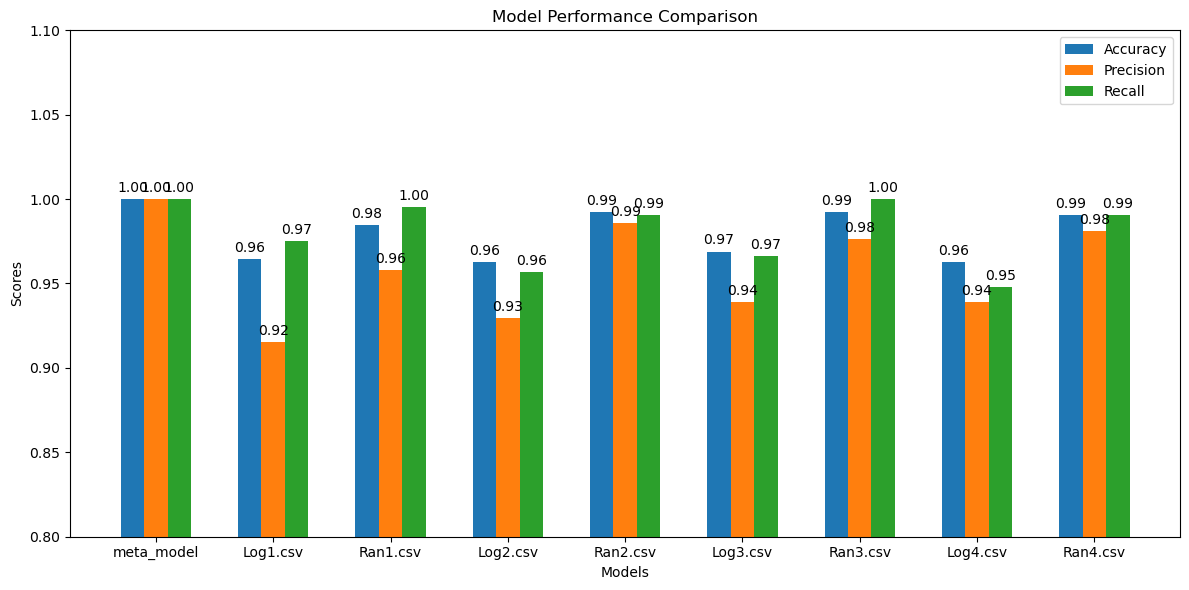

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting model names, accuracies, precisions, and recalls
model_names = [model[1] for model in results]
accuracies = [model[0][0] for model in results]
precisions = [model[0][1] for model in results]
recalls = [model[0][2] for model in results]

# Setting up the bar chart
x = np.arange(len(model_names))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, accuracies, width, label='Accuracy')
rects2 = ax.bar(x, precisions, width, label='Precision')
rects3 = ax.bar(x + width, recalls, width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

ax.set_ylim(0.80, 1.1)

# Function to attach a label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
fig.tight_layout()
plt.show()

## Clean Up Agents and Files

In [52]:
#delete_all_agents() 

In [53]:
#delete_all_assistant_files()